# Projet ARF - inpainting

In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

Préambule

In [2]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

In [3]:
X_train, y_train = load_usps("USPS_train.txt")
X_test, y_test = load_usps("USPS_test.txt")

In [4]:
lr = LinearRegression()
lr.fit(X_train,y_train)
ri = Ridge()
ri.fit(X_train,y_train)
la = Lasso()
la.fit(X_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [5]:
print("Comparison of accuracies")
cv=4
print("Linear Regression : ",100*sum(cross_val_score(lr,X_train,y_train,cv=cv))/cv,"%","et nb coeffs non nuls : ",len(np.where(lr.coef_!=0)[0]))
print("Ridge Regression : ",100*sum(cross_val_score(ri,X_train,y_train,cv=cv))/cv,"%","et nb coeffs non nuls : ",len(np.where(ri.coef_!=0)[0]))
print("Lasso Regression : ",100*sum(cross_val_score(la,X_train,y_train,cv=cv))/cv,"%","et nb coeffs non nuls : ",len(np.where(la.coef_!=0)[0]))

Comparison of accuracies
Linear Regression :  61.31002962482734 % et nb coeffs non nuls :  256
Ridge Regression :  61.347665819273836 % et nb coeffs non nuls :  256
Lasso Regression :  8.452891986755844 % et nb coeffs non nuls :  3


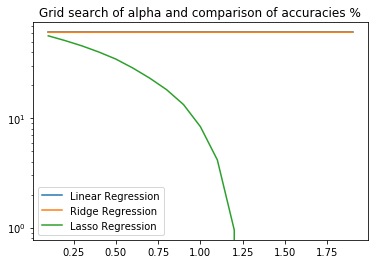

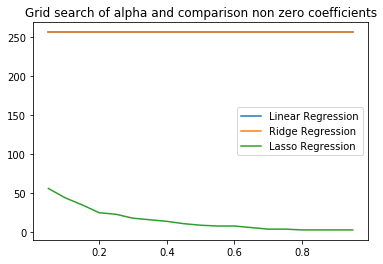

In [6]:
x = []
cv=3
y_lr = []
y_ri = []
y_la = []
for i in range(1,20):
    xx = i/10
    lr = LinearRegression()
    ri = Ridge(alpha=xx)
    la = Lasso(alpha=xx)
    x.append(xx)
    y_lr.append(100*sum(cross_val_score(lr,X_train,y_train,cv=cv))/cv)
    y_ri.append(100*sum(cross_val_score(ri,X_train,y_train,cv=cv))/cv)
    y_la.append(100*sum(cross_val_score(la,X_train,y_train,cv=cv))/cv)
plt.plot(x,y_lr,label="Linear Regression")
plt.plot(x,y_ri,label="Ridge Regression")
plt.plot(x,y_la,label="Lasso Regression")
plt.title("Grid search of alpha and comparison of accuracies %")
plt.yscale('log')
plt.legend()
x = []
plt.figure()
y_lr = []
y_ri = []
y_la = []
for i in range(1,20):
    xx = i/20
    lr = LinearRegression()
    ri = Ridge(alpha=xx)
    la = Lasso(alpha=xx)
    x.append(xx)
    lr.fit(X_train,y_train)
    ri.fit(X_train,y_train)
    la.fit(X_train,y_train)
    y_lr.append(len(np.where(lr.coef_!=0)[0]))
    y_ri.append(len(np.where(ri.coef_!=0)[0]))
    y_la.append(len(np.where(la.coef_!=0)[0]))
plt.plot(x,y_lr,label="Linear Regression")
plt.plot(x,y_ri,label="Ridge Regression")
plt.plot(x,y_la,label="Lasso Regression")
plt.title("Grid search of alpha and comparison non zero coefficients")
plt.legend()

On peut remarquer que la régression Linéaire et Ridge donnent les mêmes résultats ici, mais que la regression Lasso donne un score un peu plus faible  au début, et en augmentant alpha chute très vite, mais par contre on voit que la regression Lasso utilise dès le début très peu de coefficients non nuls, comparé  aux autres régressions, environ 80% de moins. L'utilité est d'avoir un vecteur plus sparse, n'avoir à calculer que les colonnes vraiment utiles au résultat, et généraliser plus. La regression Lasso est l'adaptation du concept de parcimonie à la régression linéaire

# Partie 2

In [29]:
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

In [78]:
def read_im(path):
    img = plt.imread(path)/255
    img = rgb_to_hsv(img)
    return img.astype(np.float32)

In [79]:
def show_img(img):
    img = hsv_to_rgb(img)
    plt.imshow(img)

In [80]:
def get_patch(i,j,h,im):
    if i-h<0 or j-h<0 or i+h>=im.shape[0] or j+h>=im.shape[1]:
        return None
    return im[i-h:i+h+1,j-h:j+h+1,3]

In [81]:
def noise(img,prc):
    img = np.copy(img)
    shape = img.shape 
    img = img.reshape((-1,3))
    n = img.shape[0]
    idxs = np.random.randint(0,high=n,size=int(n*prc))
    for i in idxs:
        img[i] = np.array([0.0,0.0,0.0])
    img = img.reshape((shape[0], shape[1], 3))
    return img

In [82]:
def delete_rect(img,i,j,height,width):
    img = np.copy(img)
    for a in range(i,i+width):
        for b in range(j,j+height):
            img[a,b] = np.array([0.0,0.0,0.0])
    return img

In [83]:
def get_all_patch_missing_value(im, h, step=1):
    tab = []
    for i in range(h,im.shape[0]-h,step):
        for j in range(h,im.shape[1]-1,step):
            patch = get_patch(i,j,h,im)
            if not np.any(patch.reshape((-1,3))!=np.zeros((1,3)),axis=0):
                tab.append(patch)
    return tab

In [84]:
def vec_to_patch(vec):
    return vec.reshape((-1,-1,3))
def patch_to_vec(patch):
    return patch.reshape((-1))

In [85]:
def get_dic(im, h, step=1):
    tab = []
    for i in range(h,im.shape[0]-h,step):
        for j in range(h,im.shape[1]-1,step):
            patch = get_patch(i,j,h,im)
            if not np.all(patch.reshape((-1,3))==np.zeros((1,3)),axis=0):
                tab.append(patch)
    return tab

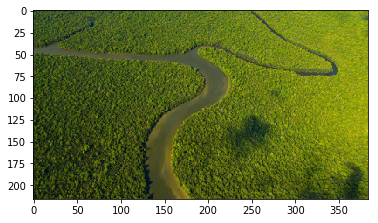

In [86]:
img = read_im("borneo_small.jpg")
show_img(img)

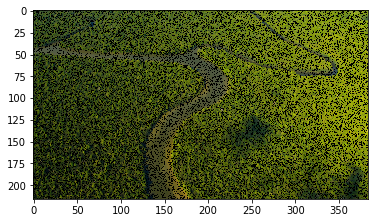

In [87]:
img_noise = noise(img,0.3)
show_img(img_noise)

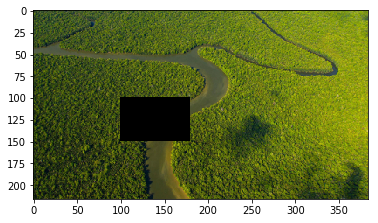

In [93]:
img_rect = delete_rect(img,100,100,80,50)
show_img(img_rect)

In [94]:
a = get_all_patch_missing_value(img_noise,3)
b = get_dic(img_noise,3)
print(a.shape,b.shape)

IndexError: index 3 is out of bounds for axis 2 with size 3